Крок 1. Завантаження данних Autos

In [1]:

from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor


with open('../datasets/mod_05_topic_10_various_data.pkl', 'rb') as fl:
    datasets = pickle.load(fl)

# %%

autos = datasets['autos']

Крок 2. Перелік дискретних ознак

In [2]:

# Визначення дискретних ознак
categorical_features = autos.select_dtypes(include=['object']).columns
discrete_features = categorical_features.tolist() + ['num_of_doors', 'num_of_cylinders']

# Кодування категоріальних ознак
for col in discrete_features:
    le = LabelEncoder()
    autos[col] = le.fit_transform(autos[col])

Крок 3.  Розрахунок показника взаємної інформації для вхідних ознак і цільової змінної price за допомогою методу mutual_info_regression() з пакета sklearn

In [3]:
# Розрахунок показника взаємної інформації
X = autos.drop(columns=['price'])
y = autos['price']

mi_scores = mutual_info_regression(X, y, discrete_features=X.columns.isin(discrete_features))
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

mi_series


engine_size          0.920039
curb_weight          0.916663
highway_mpg          0.900319
horsepower           0.874654
city_mpg             0.800598
width                0.674113
length               0.615042
wheel_base           0.587384
make                 0.544943
bore                 0.494386
fuel_system          0.484642
stroke               0.382627
height               0.365267
drive_wheels         0.333158
num_of_cylinders     0.329533
peak_rpm             0.226237
engine_type          0.151239
compression_ratio    0.105528
aspiration           0.087994
body_style           0.079849
fuel_type            0.048139
engine_location      0.035329
num_of_doors         0.010938
dtype: float64

Крок 4. Побудова регресійної моделі для оцінки важливості ознак

In [4]:
# Побудова регресійної моделі для оцінки важливості ознак
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

feature_importance = model.feature_importances_
fi_series = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)
fi_series

engine_size          0.627867
curb_weight          0.171675
horsepower           0.048444
highway_mpg          0.030372
width                0.020232
num_of_cylinders     0.016927
make                 0.016760
length               0.013035
wheel_base           0.011842
city_mpg             0.006749
bore                 0.006614
fuel_system          0.006555
peak_rpm             0.005080
stroke               0.004770
body_style           0.003767
drive_wheels         0.002850
height               0.001650
compression_ratio    0.001570
engine_type          0.001197
aspiration           0.001116
num_of_doors         0.000929
engine_location      0.000000
fuel_type            0.000000
dtype: float64

Крок 5. Масштабування, Об'єднання  та сортування даних

In [5]:
# Масштабування показників взаємної інформації та важливості ознак
mi_rank = mi_series.rank(pct=True)
fi_rank = fi_series.rank(pct=True)

# Об'єднання даних для візуалізації
comparison_df = pd.DataFrame({'MI Scores': mi_rank, 'GB Scores': fi_rank})
comparison_df = comparison_df.reset_index().melt(id_vars='index', var_name='variable', value_name='value')

# Сортування даних за значенням MI Scores
comparison_df_sorted = comparison_df.sort_values(by=['value', 'index'], ascending=[False, True])

Крок 6. Візуалізація  типу grouped barsplots для порівняння обох наборів за допомогою методу catplot() з пакета seaborn

<Figure size 1000x800 with 0 Axes>

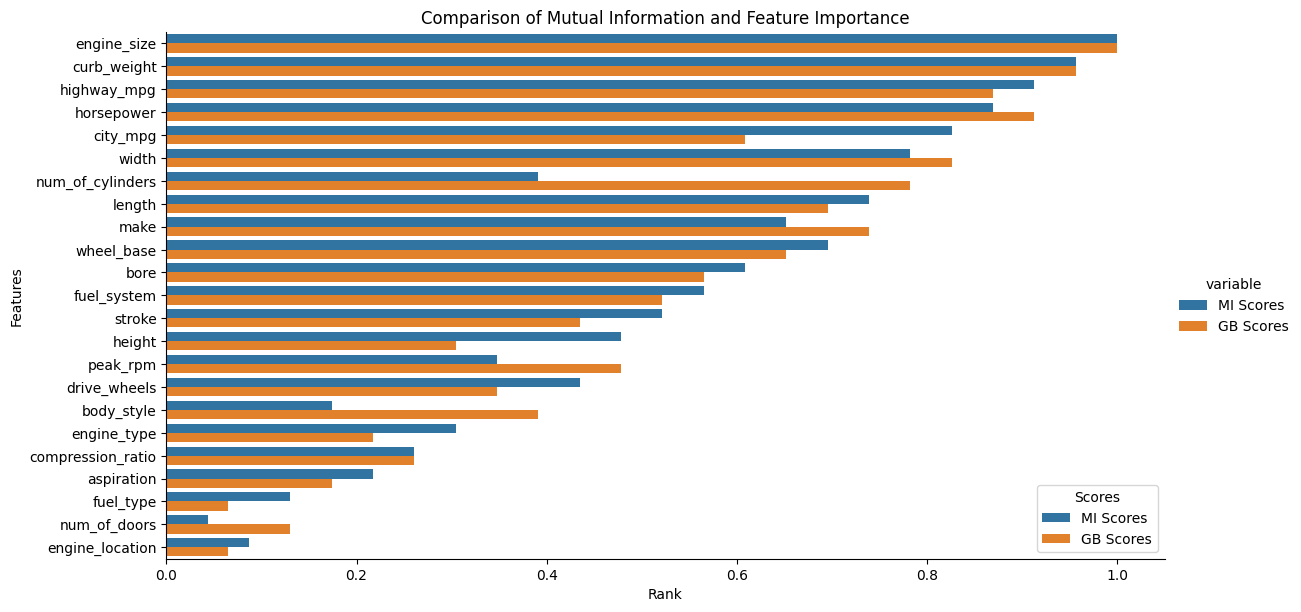

In [6]:
# Візуалізація
plt.figure(figsize=(10, 8))
sns.catplot(data=comparison_df_sorted, x='value', y='index', hue='variable', kind='bar', height=6, aspect=2)
plt.title('Comparison of Mutual Information and Feature Importance')
plt.xlabel('Rank')
plt.ylabel('Features')
plt.legend(title='Scores')
plt.show()

Крок 7.  Аналіз та висновки




In [7]:
# Отримання топ-5 ознак за значеннями MI Scores і GB Scores
top_mi = mi_series.sort_values(ascending=False).head(5)
top_gb = fi_series.sort_values(ascending=False).head(5)

top_mi, top_gb


(engine_size    0.920039
 curb_weight    0.916663
 highway_mpg    0.900319
 horsepower     0.874654
 city_mpg       0.800598
 dtype: float64,
 engine_size    0.627867
 curb_weight    0.171675
 horsepower     0.048444
 highway_mpg    0.030372
 width          0.020232
 dtype: float64)

# Аналіз:
* curb_weight: Має високі значення як за MI Scores (0.917), так і за GB Scores (0.172), що підтверджує його значний вплив на ціну автомобіля, хоча оцінка моделі вважає його менш важливим у порівнянні з engine_size.
* engine_size: Високі значення як за MI Scores (0.92), так і за GB Scores (0.628) свідчать про його ключову роль у визначенні ціни автомобіля.
* horsepower: Значення MI Scores (0.875) і GB Scores (0.048) показують, що ця ознака важлива для взаємної інформації, але менш важлива для прогнозної моделі.
* highway_mpg: Високий MI Score (0.90) та низький GB Score (0.030) свідчать про те, що ця ознака важлива для взаємної інформації, але менш важлива для моделі.
* city_mpg: Високий MI Score (0.80) показує, що ця ознака є важливою для взаємної інформації, хоча вона не входить у топ-5 за значенням GB Scores.

# Висновки:

* engine_size та curb_weight є ключовими ознаками для прогнозування ціни автомобіля за обома оцінками, що підкреслює їхню важливість.
* Деякі ознаки, такі як horsepower та highway_mpg, мають високі значення MI Scores, але низькі GB Scores, що вказує на їхню потенційну корисність для інших моделей або в комбінації з іншими ознаками.
* Ознака width має високий GB Score (0.020), але не входить у топ-5 за MI Score, що показує, що вона може мати специфічну корисність у контексті моделі Gradient Boosting.
* Цей аналіз підтверджує важливість використання різних методів оцінки ознак для отримання комплексного розуміння їхньої корисності у прогнозних моделях.